# Plot the Annular mode indices in the CMIP6 for the extended winter



## Import modules


In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import os

from tools_AM_mod import find_month_ticks, cov_lag, find_event
month_ticks, month_ticklabels = find_month_ticks()

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# %matplotlib inline

from read_AM_mod import JRA55, CMIP6, ERA5, NAM, SAM

with open("model_list.txt", "r") as f:
    model_list = f.readlines()
    model_list = [d.replace("\n", "") for d in model_list]
# model_list.remove("CESM2")

plev = [1000.,  850.,  700.,  500.,  250.,  100.,   50.,   10.]

## Load JRA55 and CMIP6 data

In [2]:
data = ERA5(name_dir='ERA5', year_start=1950, year_end=2014, plev=plev, source_dir='cmip6')
D0 = NAM(data, index_name='NAM', annual_cycle_fft=2, running_mean=0, save_index=False)
_, NAM_mean, NAM_anomaly = D0.cal_anomaly('NAM')
D0.NAM_mean = NAM_mean
D0.NAM_anomaly = NAM_anomaly
D0.y = D0.cal_slice(month_start=11, len_slice=150)
print(D0.data.name)

D_list = []
for model in model_list:
    data = CMIP6(name_dir=model, year_start=1950, year_end=2014, plev=plev, source_dir='cmip6')
    D = NAM(data, index_name='NAM', annual_cycle_fft=2, running_mean=0, save_index=True)
    _, NAM_mean, NAM_anomaly = D.cal_anomaly('NAM')
    D.NAM_mean = NAM_mean
    D.NAM_anomaly = NAM_anomaly
    D.y = D.cal_slice(month_start=11, len_slice=150)
    print(D.data.name)
    D_list.append(D)

print(f"total number of models: {len(D_list)}")

Calculating from the original data .......
ERA5
Reading from saved data ......
ACCESS-CM2
Reading from saved data ......
BCC-ESM1
Reading from saved data ......
CanESM5
Reading from saved data ......
CESM2
Reading from saved data ......
CESM2-WACCM
Reading from saved data ......
CNRM-CM6
Reading from saved data ......
CNRM-CM6-HR
Reading from saved data ......
CNRM-ESM2
Reading from saved data ......
EC-Earth3
Reading from saved data ......
FGOALS-f3-L
Reading from saved data ......
FGOALS-g3
Reading from saved data ......
GFDL-ESM4
Reading from saved data ......
HadGEM3-GC31-LL
Reading from saved data ......
HadGEM3-GC31-MM
Reading from saved data ......
INM-CM4
Reading from saved data ......
INM-CM5
Reading from saved data ......
IPSL-CM6A-LR
Reading from saved data ......
KACE
Reading from saved data ......
MIROC6
Reading from saved data ......
MIROC-ES2L
Reading from saved data ......
MPI-ESM-1-2-HAM
Reading from saved data ......
MPI-ESM1-2-HR
Reading from saved data ......
MPI-ES

## Plot the annual cycle of Z, STD, and auto-covariance function for given `p_level`

In [10]:
# p_level = 10
p_level = 500

In [11]:
# mean, STD
def get_AM_data(D):
    # D = D_list[model_list.index('HadGEM3-GC31-LL')]
    # print(D.name)

    ysize_D = D.data.length_of_year # including calendar = "360_day"
    time_D = np.linspace(1, ysize_D, ysize_D)
    ki = np.isin(D.data.level, p_level)
    NAM_mean_D = np.squeeze(D.NAM_mean[:, ki])
    NAM_std_D = np.std(D.NAM_anomaly[:, ki].reshape(-1, ysize_D), axis=0)
    
    NAM_mean = np.interp(time, time_D*ysize/ysize_D, NAM_mean_D)
    NAM_std = np.interp(time, time_D*ysize/ysize_D, NAM_std_D)

    return NAM_mean, NAM_std

ysize = D0.data.length_of_year # including calendar = "360_day"
time = np.linspace(1, ysize, ysize)
ki = np.isin(D0.data.level, p_level)
NAM_mean0 = np.squeeze(D0.NAM_mean[:, ki])
NAM_std0 = np.std(D0.NAM_anomaly[:, ki].reshape(-1, ysize), axis=0)

NAM_mean = np.empty((len(D_list), *NAM_mean0.shape))
NAM_std = np.empty((len(D_list), *NAM_std0.shape))
for i, D in enumerate(D_list):
    NAM_mean[i, :], NAM_std[i, :] = get_AM_data(D)


In [12]:
# autocorrelation
lag_time = 40
lags = np.arange(0, lag_time+1)

k = np.isin(D0.data.level, p_level)
Ct0 = np.array([cov_lag(D0.y[:, :, k], lag) for lag in lags])

Ct = np.empty((len(D_list), *Ct0.shape))
for i, D in enumerate(D_list):
    k = np.isin(D.data.level, p_level)
    Ct[i, :] = np.array([cov_lag(D.y[:, :, k], lag) for lag in lags])

Text(0.5, 1.0, 'AutoCorr(Z500), winter')

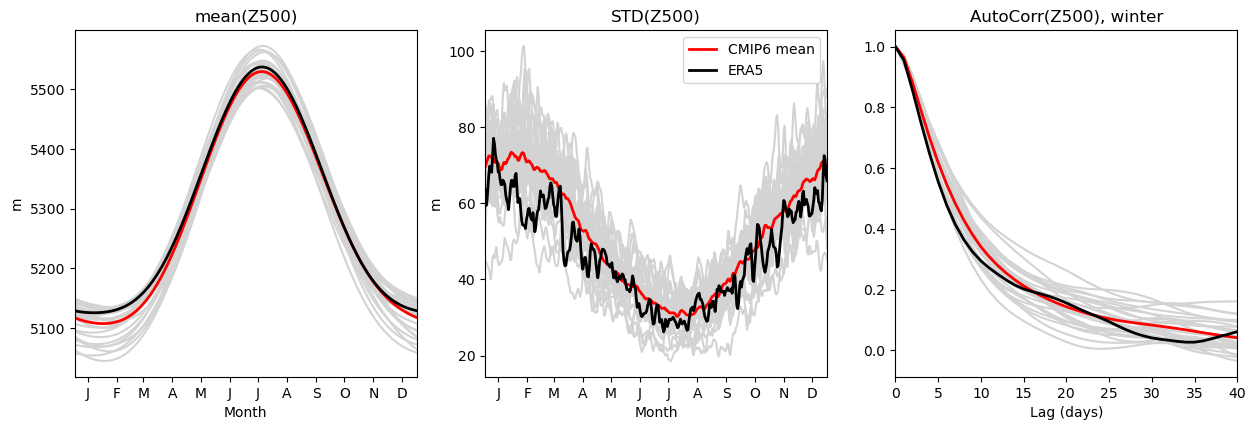

In [13]:
# fig = plt.figure(figsize=(12,3.6))
fig = plt.figure(figsize=(15,4.5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(time, NAM_mean.T, color='lightgray')
ax1.plot(time, NAM_mean.mean(axis=0), color='r', linewidth=2, label='CMIP6 mean')
ax1.plot(time, NAM_mean0, color='k', linewidth=2, label=D0.data.name)
ax1.set_xlim((1, 365))
ax1.set_xticks(month_ticks)
ax1.set_xticklabels(month_ticklabels)
ax1.set_xlabel('Month')
ax1.set_ylabel('m')
ax1.set_title(f'mean(Z{p_level:.0f})')
# ax1.legend()

ax1 = fig.add_subplot(1, 3, 2)
ax1.plot(time, NAM_std.T, color='lightgray')
ax1.plot(time, NAM_std.mean(axis=0), color='r', linewidth=2, label='CMIP6 mean')
ax1.plot(time, NAM_std0, color='k', linewidth=2, label=D0.data.name)
ax1.set_xlim((1, 365))
ax1.set_xticks(month_ticks)
ax1.set_xticklabels(month_ticklabels)
ax1.set_ylabel('m')
ax1.set_xlabel('Month')
ax1.set_title(f'STD(Z{p_level:.0f})')
ax1.legend()

ax1 = fig.add_subplot(1, 3, 3)
ax1.plot(lags, Ct.T, color='lightgray')
ax1.plot(lags, Ct.mean(axis=0), color='r', linewidth=2, label='CMIP6 mean')
ax1.plot(lags, Ct0, color='k', linewidth=2, label=D0.data.name)
ax1.set_xlim((0, lag_time))
ax1.set_xlabel('Lag (days)')
ax1.set_title(f'AutoCorr(Z{p_level:.0f}), winter')
# ax1.legend()

# plt.savefig(f'Figs/Z{p_level:.0f}_annual_cyle.pdf', transparent=True)

## Plot lagged regression


In [33]:
# lagged regression
def cal_Ct_p(D0, p_level):
    k = np.isin(D0.data.level, p_level)
    Ct_p = np.array([cov_lag(D0.y[:, :, :], lag, -D0.y[:, :, k]) for lag in lags])
    return Ct_p

lag_time = 40
lags = np.arange(0, lag_time+1)
Ct_p0 = cal_Ct_p(D0, p_level=10)

Ct_p = np.empty((len(D_list), *Ct_p0.shape))
for i, D in enumerate(D_list):
    Ct_p[i, :, :] = cal_Ct_p(D, p_level=10)


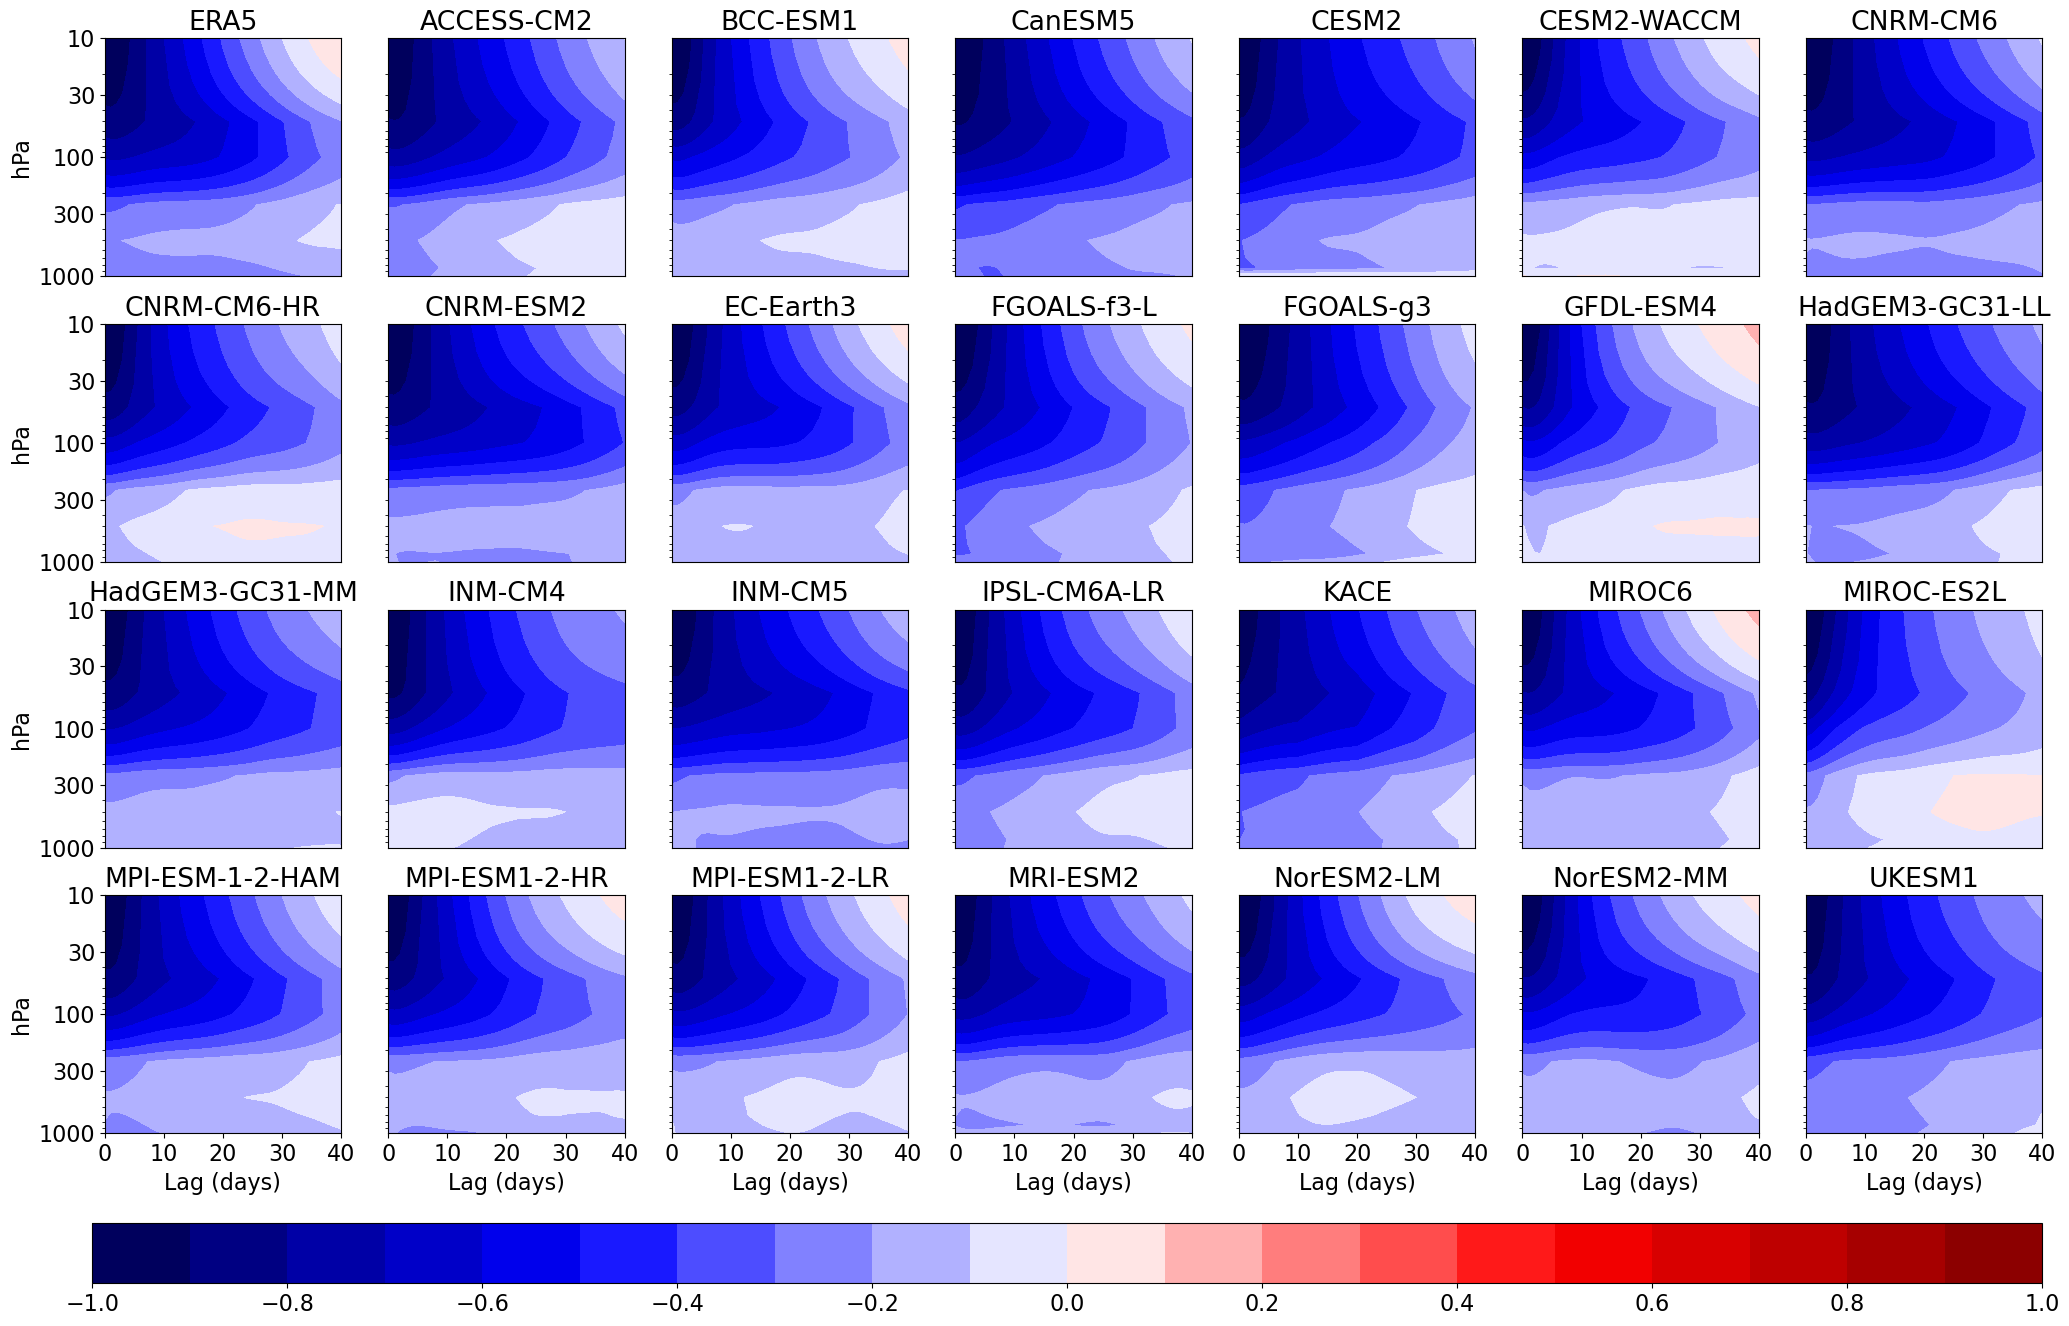

In [42]:
def plot_lag_reg(D0, Ct_p0, plot_i):
    plt.contourf(lags, D0.data.level, Ct_p0.T, np.linspace(-cmax, cmax, 21), cmap=cm)
    plt.gca().invert_yaxis()
    plt.yscale('log')
    if plot_i % 7 == 0:
        plt.yticks([10, 30, 100, 300, 1000])
        plt.ylabel('hPa')
    else:
        plt.yticks([])
    if plot_i < 21:
        plt.xticks([])
    else:
        plt.xticks([0, 10, 20, 30, 40])
        plt.xlabel('Lag (days)')
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(f"{D0.data.name}")

cmax = 1
cm = 'seismic' # 'bwr'
fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(4, 7, 1)
plot_lag_reg(D0, Ct_p0, 0)

for i, D in enumerate(D_list):
    ax1 = fig.add_subplot(4, 7, i+2)
    plot_lag_reg(D, Ct_p[i], i+1)

fig.subplots_adjust(bottom=0.15)
cax = fig.add_axes([0.12, 0.05, 0.78, 0.04])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='horizontal')
cbar.set_ticks(np.linspace(-cmax, cmax, 11))
mpl.rcParams.update({'font.size': 16})

# plt.savefig('Figs/AM_reg_all.pdf', transparent=True)

## Make composite for weak vortex events


In [16]:
lag_time = 40
threshold = -2
lags = np.arange(0, lag_time+1)
y0_neg_event, y0_num = find_event(D0.y, D0.data.level, threshold=threshold, lag_time=lag_time)

y_neg_event = np.empty((len(D_list), *y0_neg_event.shape))
y_num = np.empty((len(D_list)))
for i, D in enumerate(D_list):
    y_neg_event[i, :, :], y_num[i] = find_event(D.y, D.data.level, threshold=threshold, lag_time=lag_time)


# of events: 29(0.45)
# of events: 25(0.39)
# of events: 25(0.39)
# of events: 25(0.39)
# of events: 28(0.44)
# of events: 22(0.34)
# of events: 27(0.42)
# of events: 22(0.34)
# of events: 27(0.42)
# of events: 34(0.53)
# of events: 24(0.38)
# of events: 22(0.34)
# of events: 26(0.41)
# of events: 26(0.41)
# of events: 23(0.36)
# of events: 22(0.34)
# of events: 25(0.39)
# of events: 25(0.39)
# of events: 22(0.34)
# of events: 24(0.38)
# of events: 15(0.23)
# of events: 29(0.45)
# of events: 31(0.48)
# of events: 27(0.42)
# of events: 29(0.45)
# of events: 28(0.44)
# of events: 30(0.47)
# of events: 26(0.41)


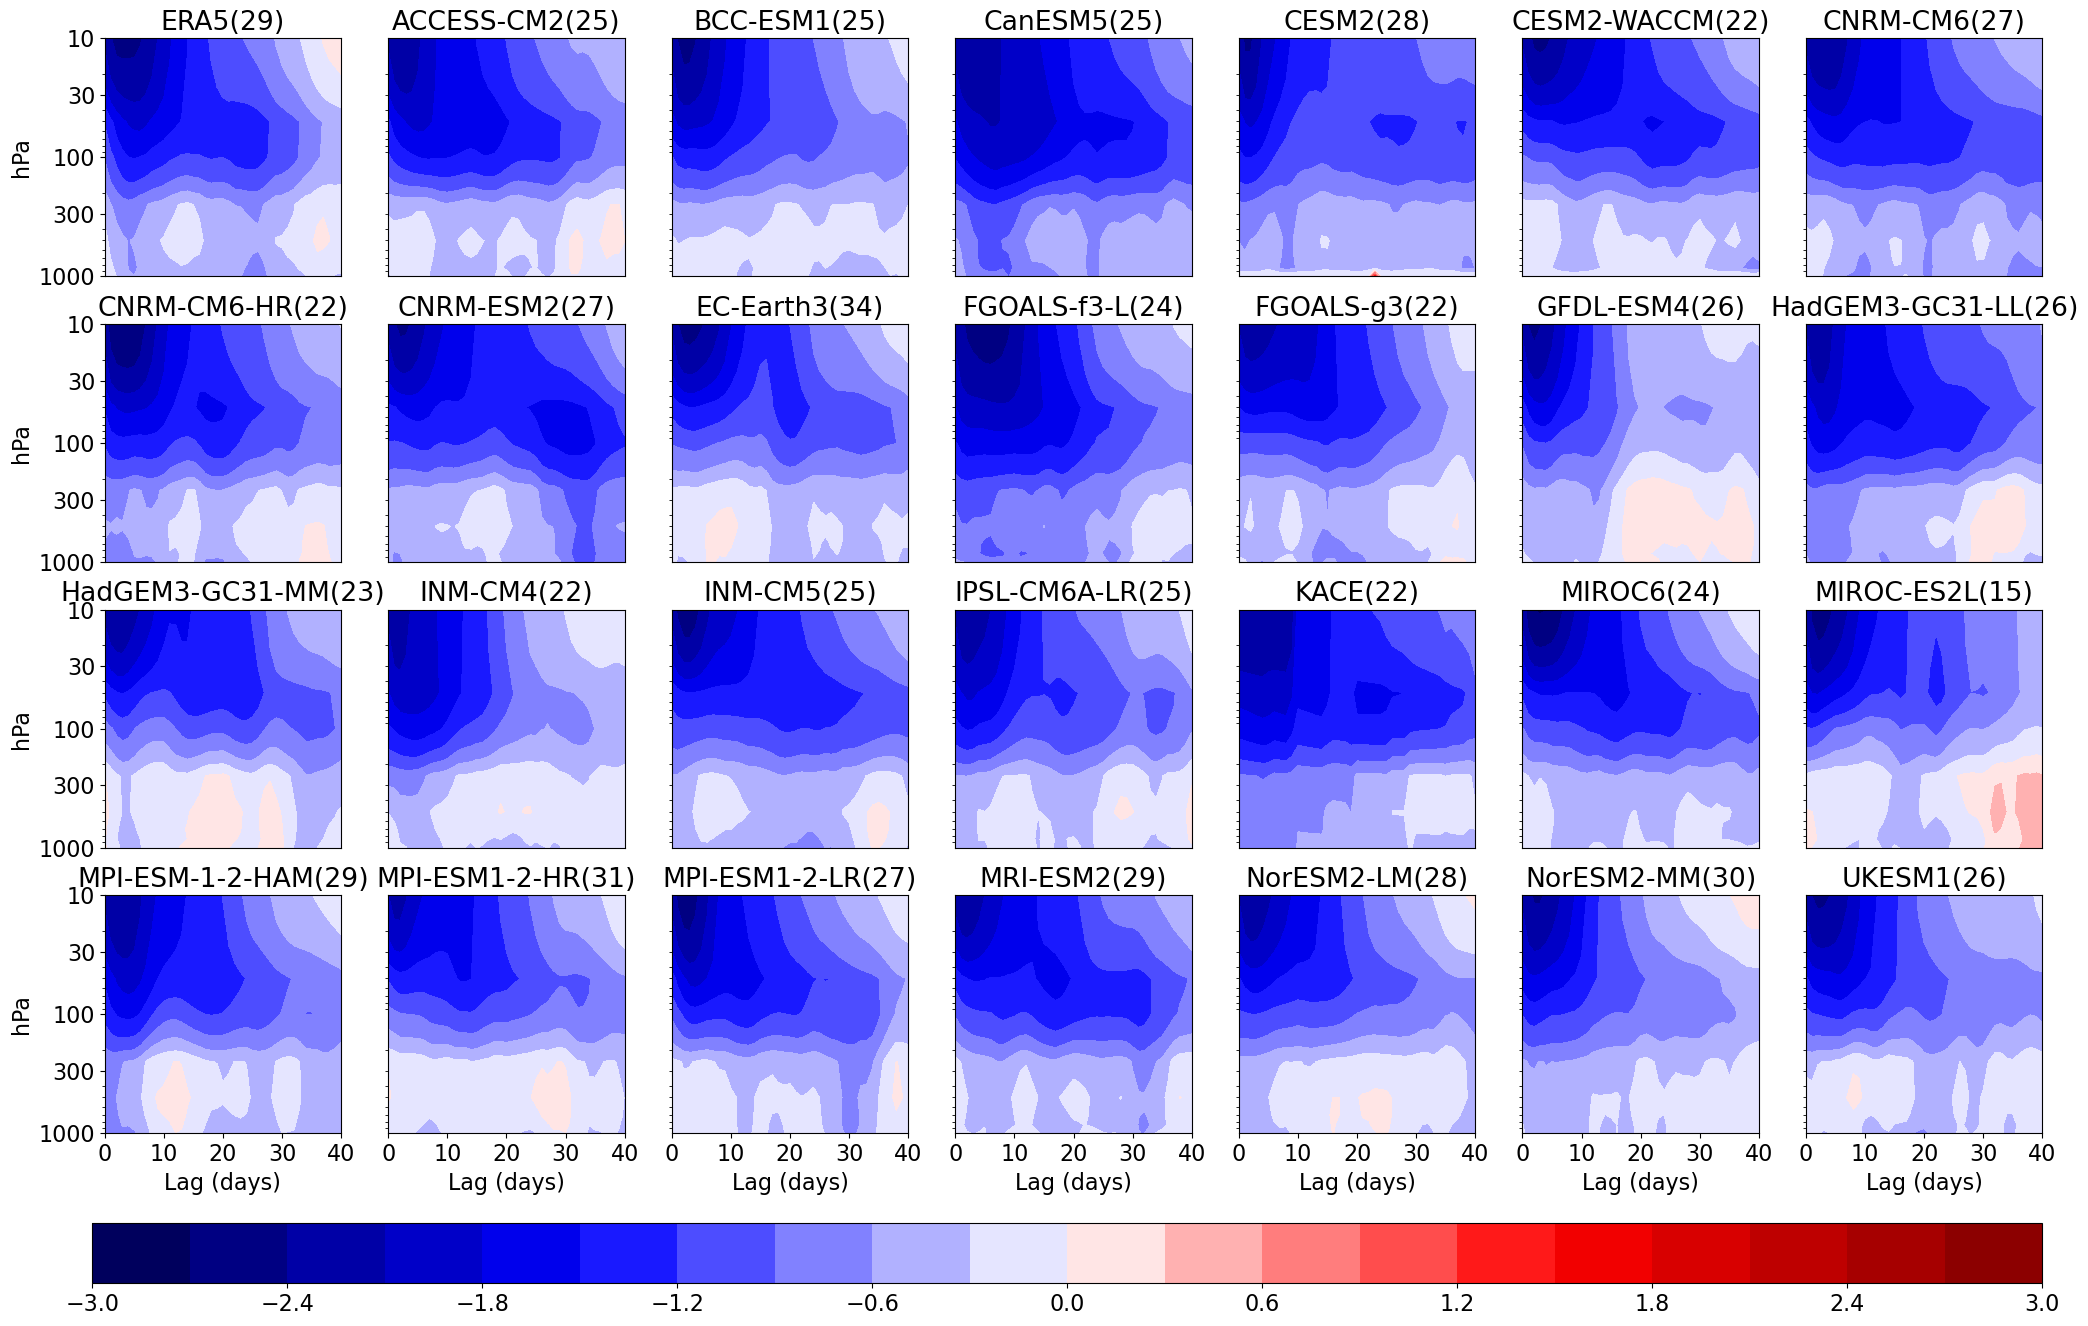

In [40]:
def plot_event(D0, y0_neg_event, y0_num, plot_i):
    plt.contourf(lags, D0.data.level, y0_neg_event.T, np.linspace(-cmax, cmax, 21), cmap=cm)
    plt.gca().invert_yaxis()
    plt.yscale('log')
    if plot_i % 7 == 0:
        plt.yticks([10, 30, 100, 300, 1000])
        plt.ylabel('hPa')
    else:
        plt.yticks([])
    if plot_i < 21:
        plt.xticks([])
    else:
        plt.xticks([0, 10, 20, 30, 40])
        plt.xlabel('Lag (days)')
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(f"{D0.data.name}({y0_num:.0f})")

cmax = 3
cm = 'seismic' # 'bwr'
fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(4, 7, 1)
plot_event(D0, y0_neg_event, y0_num, 0)

for i, D in enumerate(D_list):
    ax1 = fig.add_subplot(4, 7, i+2)
    plot_event(D, y_neg_event[i], y_num[i], i+1)

fig.subplots_adjust(bottom=0.15)
cax = fig.add_axes([0.12, 0.05, 0.78, 0.04])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='horizontal')
cbar.set_ticks(np.linspace(-cmax, cmax, 11))
mpl.rcParams.update({'font.size': 16})

# plt.savefig('Figs/AM_event_all.pdf', transparent=True)